In [1]:
import numpy as np 
import pandas as pd 
import sys 
import os 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, os.path.join(os.getcwd().split('OR_learning')[0], 'OR_learning/utils/'))
import voxel_functions as vf
import color_function as cf 
import plot_functions as pf 

ModuleNotFoundError: No module named 'logomaker'

### Loading voxels 

In [4]:
Cbc_cav_coords['Or51E2']

array([[ -5.133,  12.791,   2.204],
       [ -5.133,  12.791,   2.804],
       [ -5.133,  12.791,   3.404],
       ...,
       [  3.267,   7.991, -11.596],
       [  3.267,   7.991, -10.996],
       [  3.267,   8.591, -11.596]])

In [2]:
OR_LEARNING_PATH = os.path.join(os.getcwd().split('OR_learning')[0], 'OR_learning/')

# Open pickle file of binding cavity dictionary
Cbc_cav_coords = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_Cbc_cav_coords.pkl'))
Cbc_res_coords = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_Cbc_res_coords.pkl'))
# Response distance 
respDist = pd.read_csv(os.path.join(OR_LEARNING_PATH, 'files/Deorphanization/Resp_Olfr_distance.csv'), index_col = [0,1])[['resp_dist']]
# Remove 'Olfr' 
respDist = respDist[(~respDist.index.get_level_values(0).str.contains('Olfr')) &
                    (~respDist.index.get_level_values(1).str.contains('Olfr'))].sort_index()

In [5]:
# Create cavity voxels from coordinates 

# Make Cbc coords reordered with respDist index orders
OR_ORDER = np.sort(list(set.intersection(set(respDist.index.get_level_values(0).unique()), 
                                         set(Cbc_cav_coords.keys()))))

# Remove none intersected ORs from y
respDist = respDist[respDist.index.get_level_values(0).isin(OR_ORDER) & 
                    respDist.index.get_level_values(1).isin(OR_ORDER)]


Cbc_cav_coords = {_OR : Cbc_cav_coords[_OR] for _OR in OR_ORDER}
Cbc_res_coords = {_OR : Cbc_res_coords[_OR] for _OR in OR_ORDER}

# Voxelize binding cavity coordinates 
voxelized_Cbc, voxel_shape = vf.voxelize_cavity(list(Cbc_cav_coords.values()), 
                                                     list(Cbc_res_coords.values()), 
                                                     resolution=1)

# Output: List of 1D arrays representing voxelized space
print(np.array(voxelized_Cbc).shape)

(372, 41, 40, 36, 8)


### Quick Voxel visualization 

In [ ]:
# Visualize voxel 
colormap = cf.distinct_colors(list(Cbc_cav_coords.keys())[0:2])

fig = pf.visualize_voxel_grid(list(voxelized_Cbc[0:2]), 
                              coordinate_labels=list(Cbc_cav_coords.keys())[0:2], 
                              color_map=colormap, 
                              opacity=0.3)
# Update layout for 3D visualization
fig.show()


### CNN 

In [76]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a dataset class for pairwise voxel comparison
class PairwiseVoxelDataset(Dataset):
    def __init__(self, voxel, y_values, or_order):
        """
        Args:
            voxel: Voxelized cavities as a numpy array.
            y_values: DataFrame with pairwise response distances.
            or_order: List of receptor names in the order of voxel data.
        """
        self.voxel = voxel
        self.index_pairs = y_values.index  # Pair indices
        self.y_values = y_values.values  # Pairwise similarity scores
        self.or_order = or_order

    def __len__(self):
        return len(self.y_values)

    def __getitem__(self, idx):
        # Get the receptor pair indices
        or1, or2 = self.index_pairs[idx]

        # Convert receptor names to voxel indices
        idx1 = self.or_order.index(or1)
        idx2 = self.or_order.index(or2)

        # Get voxel data for the pair
        voxel1 = self.voxel[idx1]
        voxel2 = self.voxel[idx2]

        # Permute voxel dimensions to match Conv3d input format
        voxel1 = torch.tensor(voxel1, dtype=torch.float32).permute(3, 0, 1, 2)  # (channels, depth, height, width)
        voxel2 = torch.tensor(voxel2, dtype=torch.float32).permute(3, 0, 1, 2)

        # Get the similarity score
        y = self.y_values[idx]

        # Return tensors
        return voxel1, voxel2, torch.tensor(y, dtype=torch.float32)


# Initialize the dataset and dataloader
dataset = PairwiseVoxelDataset(voxelized_Cbc, respDist['resp_dist'], list(OR_ORDER))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Pairwise3DCNN(nn.Module):
    def __init__(self, input_channels=8):
        super(Pairwise3DCNN, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv3d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 20 * 20 * 18 * 2, 128)  # Output size after pooling and concatenation
        self.fc2 = nn.Linear(128, 1)  # Final similarity score

    def forward(self, x1, x2):
        # Pass first voxel through convolutional layers
        x1 = F.relu(self.conv1(x1))
        x1 = self.pool(F.relu(self.conv2(x1)))

        # Pass second voxel through convolutional layers
        x2 = F.relu(self.conv1(x2))
        x2 = self.pool(F.relu(self.conv2(x2)))

        # Flatten and concatenate features from both inputs
        x1 = torch.flatten(x1, start_dim=1)
        x2 = torch.flatten(x2, start_dim=1)
        x = torch.cat((x1, x2), dim=1)

        # Fully connected layers for final similarity score
        x = F.relu(self.fc1(x))
        similarity = self.fc2(x)
        return similarity

In [ ]:
random.sample(list(range(len(dataset))), 100)

Epoch [1/10], Training Loss: 1.3129, Test Loss: 0.0337
Epoch [2/10], Training Loss: 0.0326, Test Loss: 0.0307
Epoch [3/10], Training Loss: 0.0279, Test Loss: 0.0293
Epoch [4/10], Training Loss: 0.0264, Test Loss: 0.0271
Epoch [5/10], Training Loss: 0.0259, Test Loss: 0.0273
Epoch [6/10], Training Loss: 0.0257, Test Loss: 0.0272
Epoch [7/10], Training Loss: 0.0257, Test Loss: 0.0280
Epoch [8/10], Training Loss: 0.0256, Test Loss: 0.0280
Epoch [9/10], Training Loss: 0.0254, Test Loss: 0.0279
Epoch [10/10], Training Loss: 0.0253, Test Loss: 0.0270


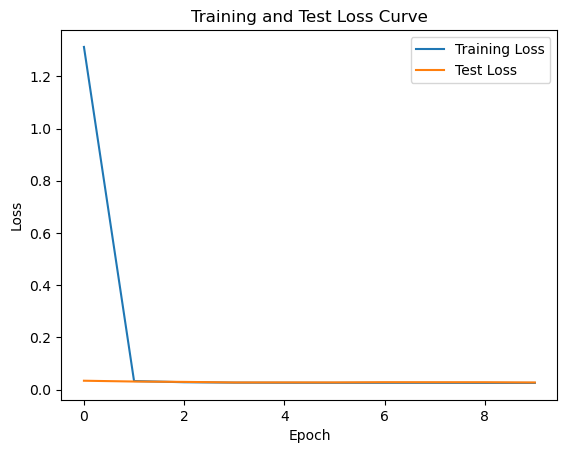

In [90]:
from torch.utils.data import random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random 


TEST_dataset = torch.utils.data.Subset(dataset, random.sample(list(range(len(dataset))), 10000))

# Split the dataset into training and test subsets
train_size = int(0.8 * len(TEST_dataset))  # 80% training, 20% testing
test_size = len(TEST_dataset) - train_size
train_dataset, test_dataset = random_split(TEST_dataset, [train_size, test_size])

# DataLoaders for training and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training parameters
num_epochs = 10  # Fewer epochs for quick testing
learning_rate = 0.001

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Pairwise3DCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Store losses for visualization
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    epoch_train_loss = 0
    model.train()

    # Training step
    for voxel1, voxel2, y in train_dataloader:
        voxel1, voxel2, y = voxel1.to(device), voxel2.to(device), y.to(device)

        # Forward pass
        outputs = model(voxel1, voxel2).squeeze()
        loss = criterion(outputs, y)
        epoch_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test data
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for voxel1, voxel2, y in test_dataloader:
            voxel1, voxel2, y = voxel1.to(device), voxel2.to(device), y.to(device)

            # Forward pass
            outputs = model(voxel1, voxel2).squeeze()
            loss = criterion(outputs, y)
            epoch_test_loss += loss.item()

    # Compute average test loss for the epoch
    avg_test_loss = epoch_test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot the loss curves
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Curve")
plt.legend()
plt.show()

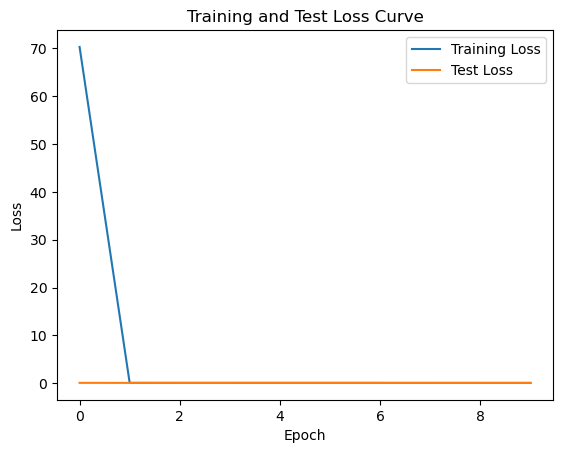

In [88]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Curve")
plt.legend()
plt.show()

In [ ]:
# Calculate MSE on the validation set
from sklearn.metrics import mean_squared_error

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for voxel1, voxel2, y in small_dataloader:
        voxel1, voxel2, y = voxel1.to(device), voxel2.to(device), y.to(device)
        outputs = model(voxel1, voxel2).squeeze()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

mse = mean_squared_error(y_true, y_pred)
print(f"Validation MSE: {mse:.4f}")

R² Score: -0.0007


/data/jlu/OR_learning/utils/plot_functions.py:97: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



<module 'matplotlib.pyplot' from '/data/jlu/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

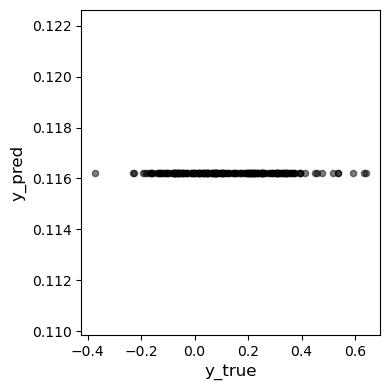

In [281]:
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2:.4f}")

pf.plot_correlation(y_true, y_pred, 
                    xlabel='y_true', ylabel='y_pred', 
                    opacity=0.5, 
                    plot_pearson_line=None, 
                    edgecolor='black', edgesize=20, 
                    figsize=[4,4])

In [ ]:
def visualize_feature_maps(layer, voxel):
    model.eval()
    with torch.no_grad():
        feature_map = layer(voxel.unsqueeze(0).to('cpu')).squeeze().cpu().numpy()

    # Visualize feature maps (first few channels)
    for i in range(min(4, feature_map.shape[0])):
        plt.imshow(feature_map[i].mean(axis=-1))  # Collapse along one axis
        plt.title(f"Feature Map Channel {i+1}")
        plt.colorbar()
        plt.show()

voxel_sample = dataset[0][0]  # A sample voxel
visualize_feature_maps(model.conv1, voxel_sample)

In [31]:
import torch
from einops import rearrange
"""
>>> filters = torch.randn(33, 16, 3, 3, 3)
>>> inputs = torch.randn(20, 16, 50, 10, 20)
>>> F.conv3d(inputs, filters)
"""
convP   = torch.nn.Conv3d(8, 16, kernel_size=3, padding = "same")
linearL = nn.Linear(8, 16 * 32) 
#----------------------

protinput = torch.randn(1, 20, 20, 20, 8) # batch, channel, height, width, depth
liginput  = torch.randn(1, 2, 2, 2, 8)

## apply conv1 operation by modifying both proteins and ligands
class Block(nn.Module):
    def __init__(self, init_dim, conv_kernel, conv_dim, linear_dim):
        super().__init__()
        self.convP = torch.nn.Conv3d(init_dim, conv_dim, kernel_size = conv_kernel, padding = "same")
        self.linL  = torch.nn.Linear(init_dim, conv_dim * linear_dim)
        self.outL  = torch.nn.Linear(linear_dim, init_dim)
        self.linear_dim = linear_dim
        self.conv_dim   = conv_dim
        self.init_dim   = init_dim

    def forward(self, protinput, liginput):
        ## apply convP on protinput
        prot = rearrange(protinput, "batch b h d c -> batch c b h d")
        
        prot = F.gelu(self.convP(prot)) # 1, conv_dim, b, w, h
        lig  = self.linL(liginput) # 1, 2, 2, 2, conv_dim * linear_dim
        ligc  = rearrange(lig, "1 b h d (c2 c1) -> c2 c1 b h d", c2 = self.linear_dim, c1 = self.conv_dim) # 
        prot = torch.nn.functional.conv3d(prot, ligc, padding = "same") #1, linear_dim, b, h, d
        
        prot = rearrange(prot, "1 c b h d -> 1 b h d c")
        
        return self.outL(F.gelu(prot))
    
class Inference(nn.Module):
    def __init__(self, no_blocks, init_dim, conv_kernel, conv_dim, linear_dim):
        super().__init__()
        self.blocks = nn.ModuleList([Block(init_dim = init_dim, conv_kernel = conv_kernel, conv_dim = conv_dim, linear_dim = linear_dim)
                                     for i in range(no_blocks)])
        self.final  = nn.Linear(init_dim, 1)
        return
    
    def forward(self, prot, lig):
        for modx in self.blocks:
            prot = prot + modx(prot, lig)
        prot = self.final(prot).squeeze(dim = -1)
        return prot 
    
model = Inference(3, 8, 2, 16, 32)

In [32]:
lig = torch.randn(1, 2, 2, 2, 8)
prot = torch.randn(1, 20, 20, 20, 8)
out  = model(prot, lig)

In [34]:
likelihood = torch.sum(out, dim = [1,2,3])

In [35]:
likelihood

tensor([43.4360], grad_fn=<SumBackward1>)